In [3]:
import os
import sys
import json
from pathlib import Path
sys.path.append(os.path.abspath('../src'))

# ----------- local imports ----------- 
from utils import show_images, get_frame, get_frame_test, get_info_from_seqinfo
from constants import TRAIN_PATH, TEST_PATH
from dataset import df_train, get_vid_img_path, get_vid_gt_path

In [4]:
from pathlib import Path
from tqdm.auto import tqdm

import cv2
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# ============== Models ============== 
from transformers import DetrImageProcessor, DetrForObjectDetection
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
import supervision as sv # tracker 
from ultralytics import YOLO # yolo model
# shut down loggings
import logging
logging.getLogger("ultralytics").setLevel(logging.ERROR)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = torch.Generator(device=device).manual_seed(42)

device

device(type='cuda')

In [5]:
image = get_frame("02", 1)
width, height = image.size

# DETR

In [5]:
detr_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
detr_model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", revision="no_timm").to(device)

In [71]:
inputs = detr_processor(images=image, return_tensors="pt").to(device)

with torch.no_grad():
    outputs = detr_model(**inputs)


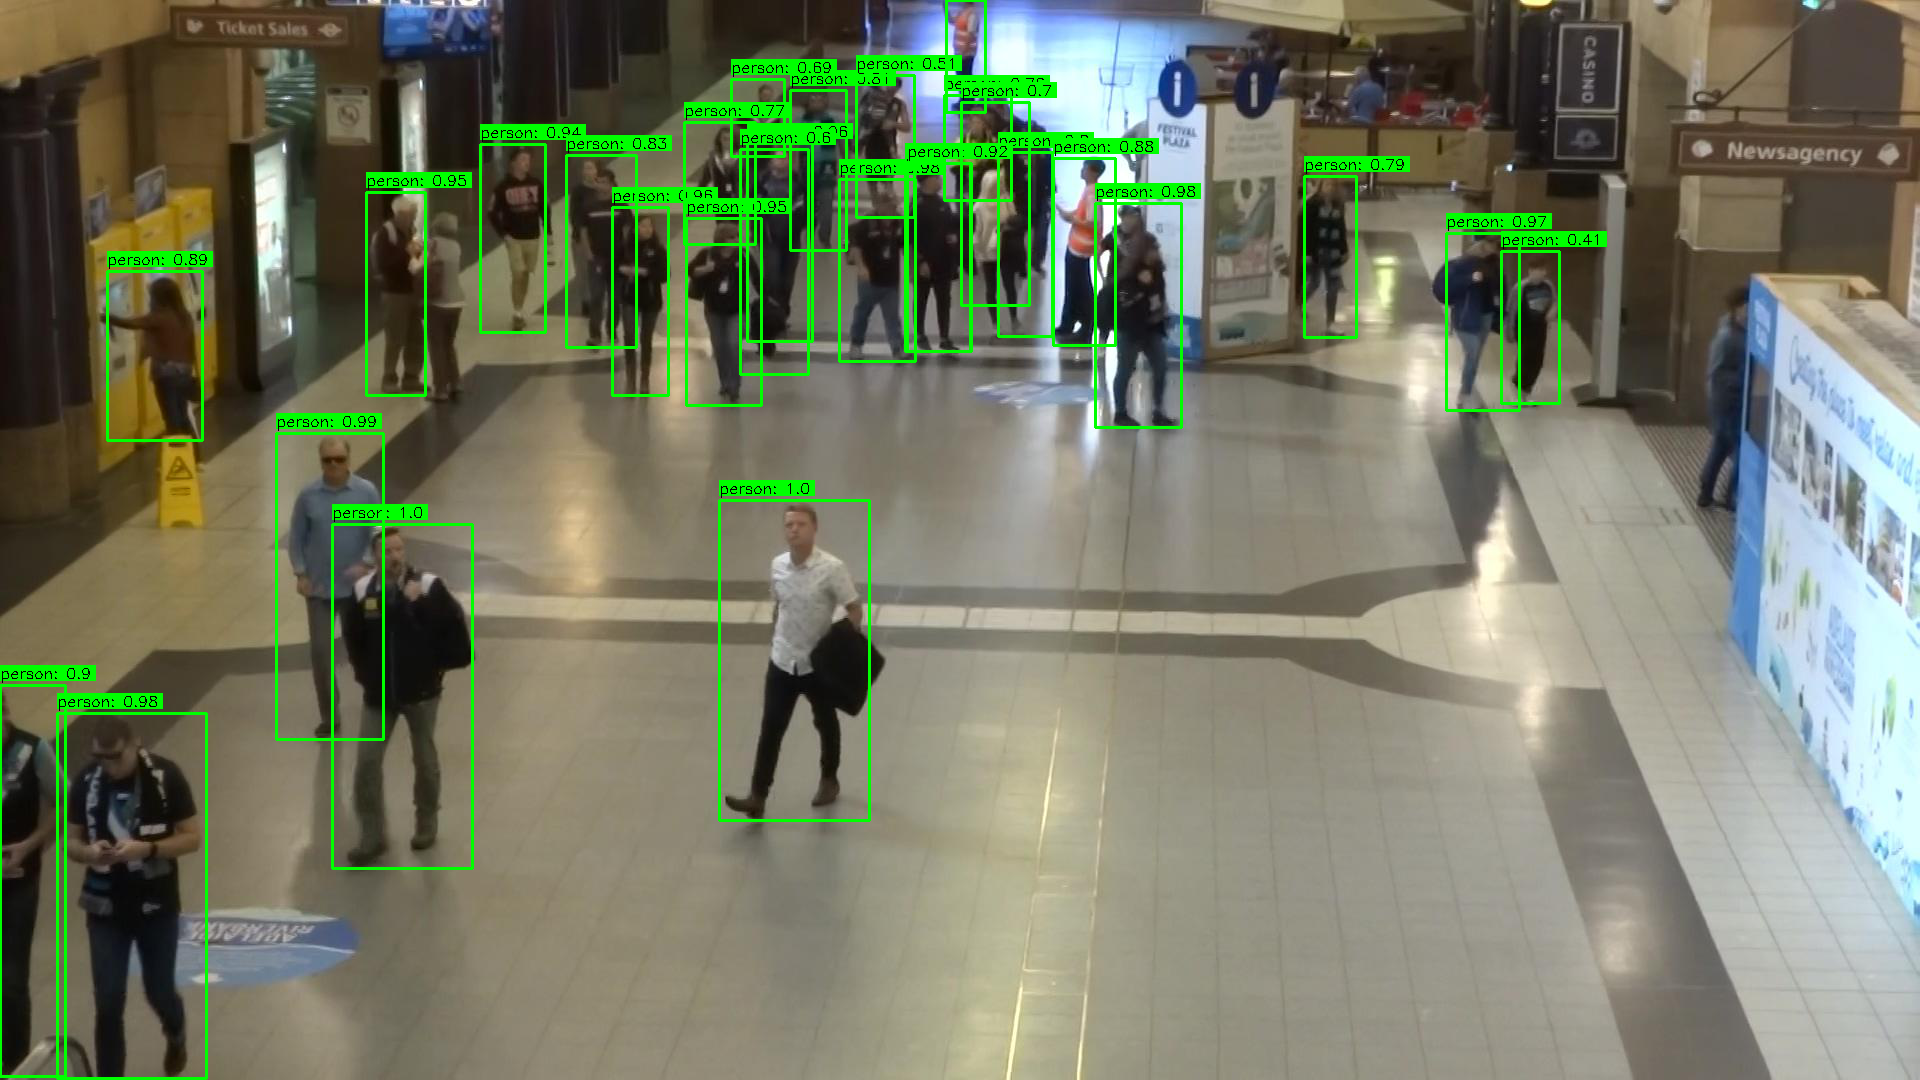

In [76]:
threshold = 0.3

# post process boxes
results = detr_processor.post_process_object_detection(outputs, target_sizes=torch.tensor([[height, width]]), threshold=threshold)[0]

image_np = np.array(image)
# Draw bounding boxes
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    label_text = f"{detr_model.config.id2label[label.item()]}: {round(score.item(), 2)}"
    if "person" not in label_text: continue 
        
    box = [round(i, 2) for i in box.tolist()]
    x1, y1, x2, y2 = map(int, box)
    
    cv2.rectangle(image_np, (x1, y1), (x2, y2), (0, 255, 0), 2)        
    text_size = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)[0]
    text_x, text_y = x1, y1 - 5
    cv2.rectangle(image_np, (text_x, text_y - text_size[1] - 3), (text_x + text_size[0] + 3, text_y), (0, 255, 0), -1)
    cv2.putText(image_np, label_text, (text_x, text_y - 2), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))

Image.fromarray(image_np)

# Faster RCNN resnet 50

In [ ]:
rcnn_model  = fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT).to(device)

In [ ]:
rcnn_model.eval()

to_tensor = transforms.ToTensor()
image_tensor = to_tensor(image).to(device)

with torch.no_grad():
    outputs = rcnn_model([image_tensor])
    

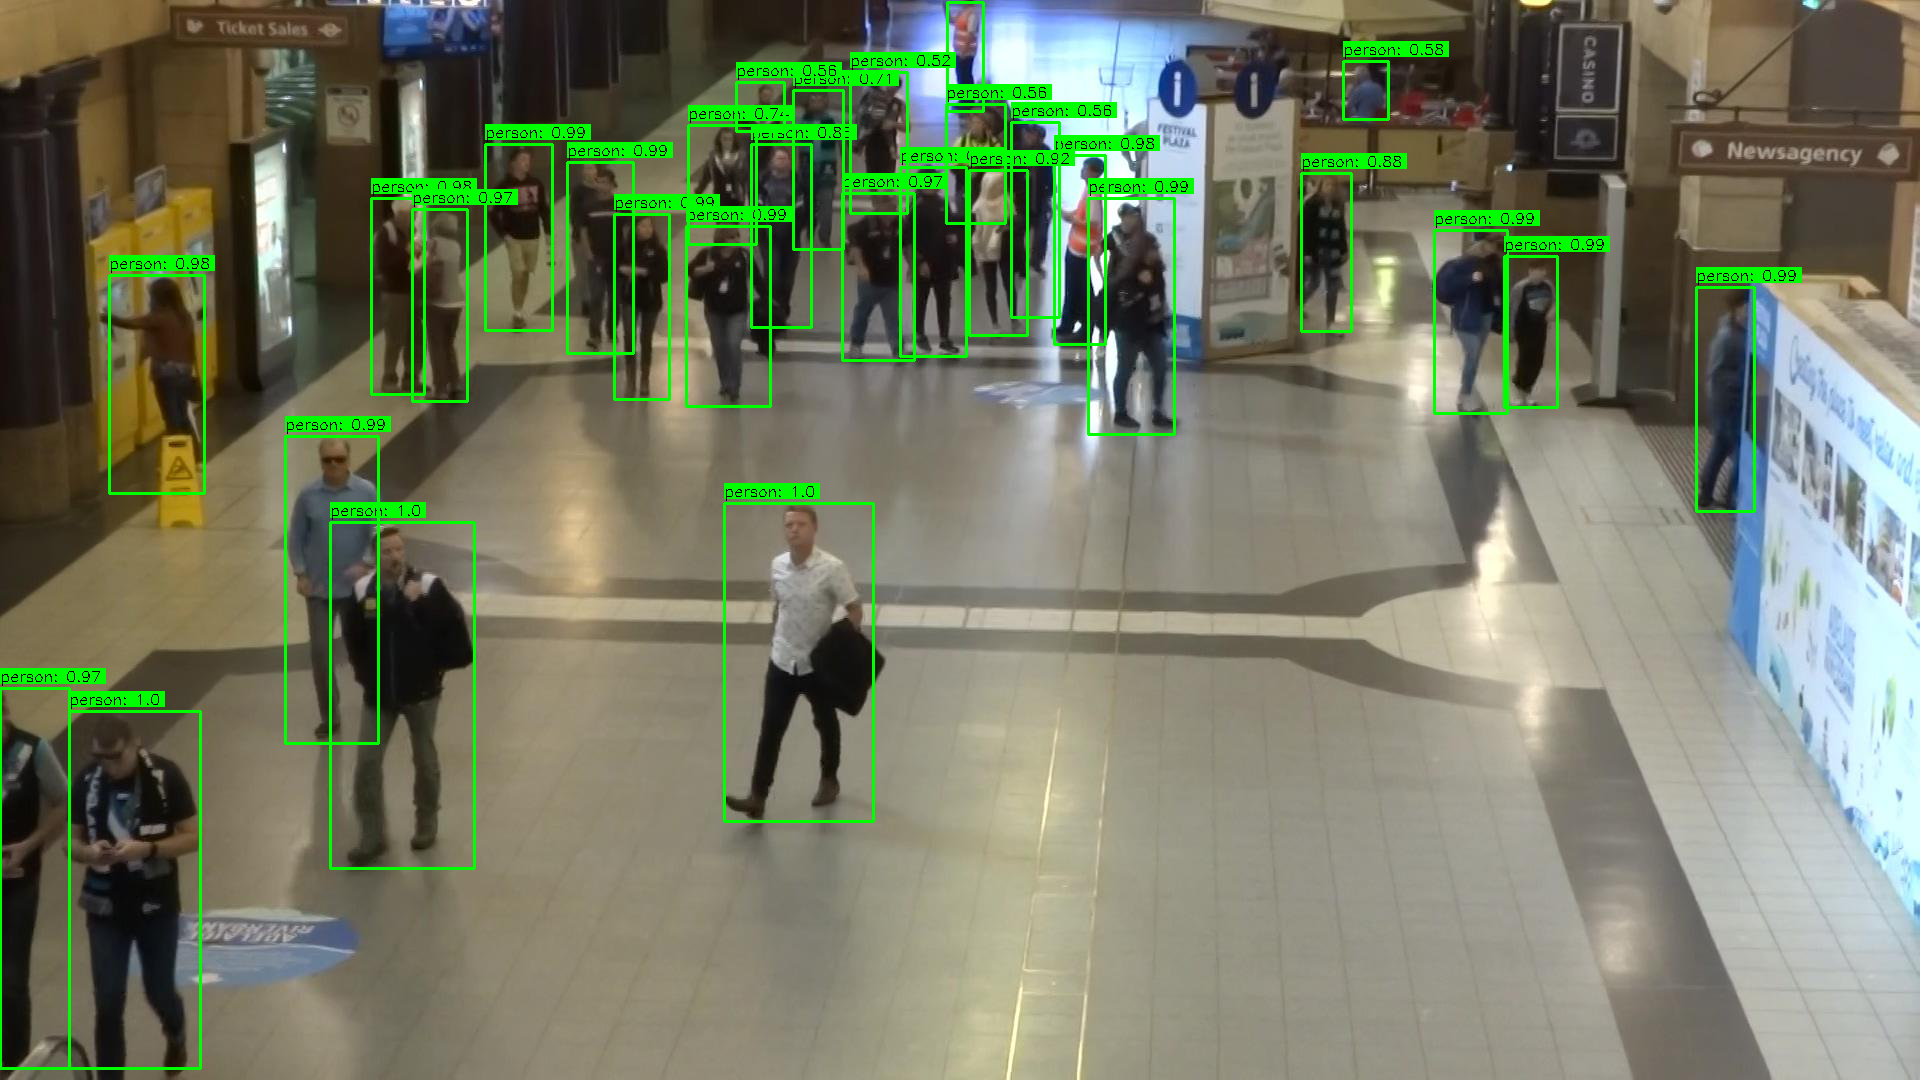

In [9]:
categories = FasterRCNN_ResNet50_FPN_Weights.DEFAULT.meta["categories"]

image_np = np.array(image)
# Draw bounding boxes
for score, label, box in zip(outputs[0]["scores"], outputs[0]["labels"], outputs[0]["boxes"]):
    label_text = f"{categories[label.item()]}: {round(score.item(), 2)}"
    if "person" not in label_text: continue 
    if score < 0.5: continue
        
    box = [round(i, 2) for i in box.tolist()]
    x1, y1, x2, y2 = map(int, box)
    
    cv2.rectangle(image_np, (x1, y1), (x2, y2), (0, 255, 0), 2)        
    text_size = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)[0]
    text_x, text_y = x1, y1 - 5
    cv2.rectangle(image_np, (text_x, text_y - text_size[1] - 3), (text_x + text_size[0] + 3, text_y), (0, 255, 0), -1)
    cv2.putText(image_np, label_text, (text_x, text_y - 2), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))


Image.fromarray(image_np)


# YOLO 11 n

In [10]:
yolo_model = YOLO("../models/yolo11n.pt").to(device)

In [57]:
with torch.no_grad():
    outputs = yolo_model(image)

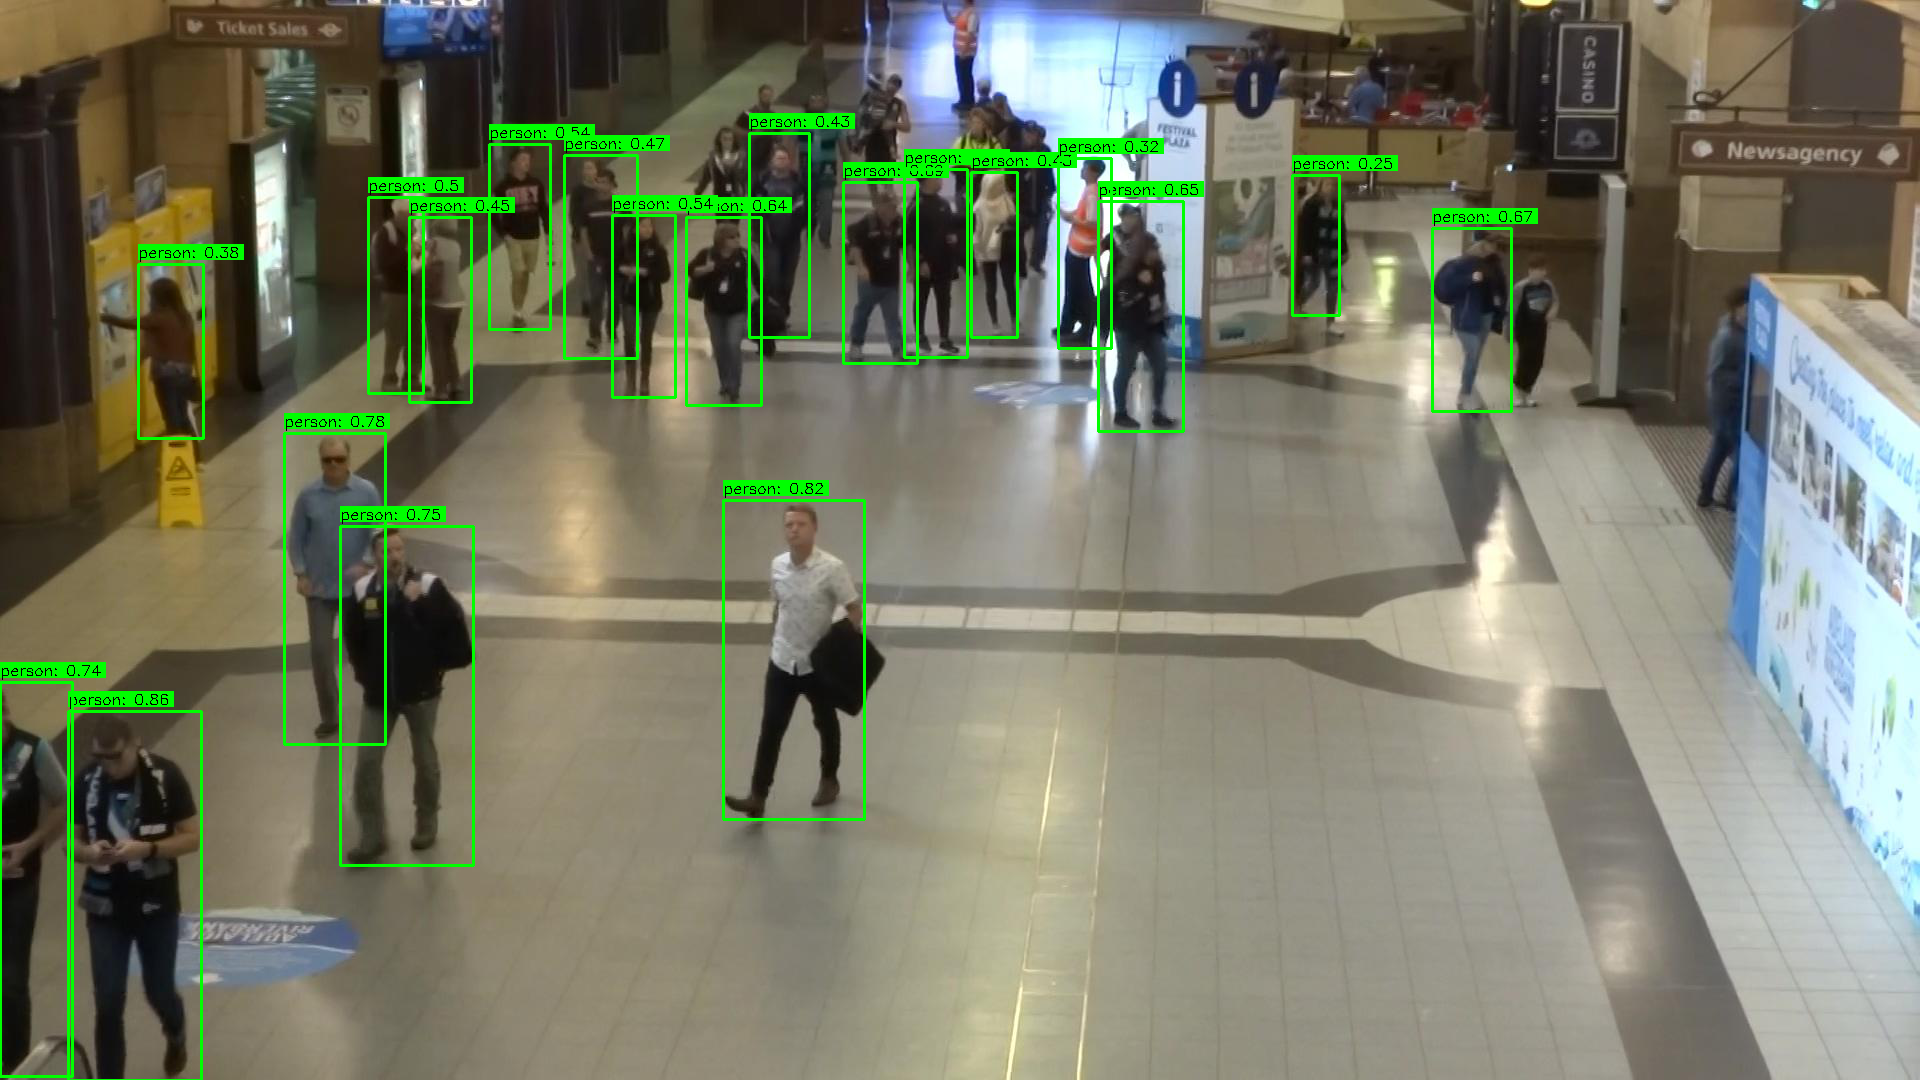

In [69]:
categories = outputs[0].names
results = outputs[0].boxes

image_np = np.array(image)
# Draw bounding boxes
for score, label, box in zip(results.conf, results.cls, results.xyxy):
    label_text = f"{categories[label.item()]}: {round(score.item(), 2)}"
    if "person" not in label_text: continue 
    # if score < 0.1: continue
        
    box = [round(i, 2) for i in box.tolist()]
    x1, y1, x2, y2 = map(int, box)
    
    cv2.rectangle(image_np, (x1, y1), (x2, y2), (0, 255, 0), 2)        
    text_size = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)[0]
    text_x, text_y = x1, y1 - 5
    cv2.rectangle(image_np, (text_x, text_y - text_size[1] - 3), (text_x + text_size[0] + 3, text_y), (0, 255, 0), -1)
    cv2.putText(image_np, label_text, (text_x, text_y - 2), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))


Image.fromarray(image_np)